In [1]:
"""Basic script for loading the PROTEINS dataset and running training scrip with it.
To run it install pytorch for your OS and config from https://pytorch.org/get-started/locally/
and install PyG https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html"""

'Basic script for loading the PROTEINS dataset and running training scrip with it.\nTo run it install pytorch for your OS and config from https://pytorch.org/get-started/locally/\nand install PyG https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html'

In [2]:
"""Imports"""
import torch
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch.nn import BCELoss
import matplotlib.pyplot as plt

from grph_conv import GCNConv, ChebConv, DConv, DCRNN

/home/pcend/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'torch_sparse'

In [107]:
"""setting device on GPU if available, else CPU"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [108]:
"""Load the data, wrap it around DataLoader (utility that acts as batch generator).
Train/val split is done arbitrarely. This dataset does not contain edge features. Only 
Node features, edges and graph label."""

dataset_raw = TUDataset(root='', name='PROTEINS', use_node_attr=True, use_edge_attr=True)
train_ds = DataLoader(dataset_raw[:1000], batch_size=32, shuffle=True)
val_ds = DataLoader(dataset_raw[1000:], batch_size=32)

In [109]:
class GCN(torch.nn.Module):
    """Create GCN module. It is a neural network that accepts graphs of varying shapes as input, and returns 
    the label of a given graph (molecule or not). It is based on classic GCNConv, other methods has to be applied here."""
    def __init__(self, n_node_features, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(n_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim)
        self.linear1 = torch.nn.Linear(hidden_dim, 1)
        
    def forward(self, data):
        x, edge_index, batch_size = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = global_mean_pool(x,batch_size)
        x = self.linear1(x)
        out = torch.sigmoid(x)
        return torch.squeeze(out)

In [110]:
"""Initializing the network and optimizer. For debugging purposes the network runs on CPU."""
model = GCN(dataset_raw.num_node_features, 16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [111]:
def check_accuracy(data_loader, model):
  num_correct = 0
  num_samples = 0
  model.eval()

  with torch.no_grad():
    for data in data_loader:
        data.to(device)
        scores = model(data)
        predictions = (scores > 0.5).long()
        num_correct += (predictions == data.y).sum()
        num_samples += predictions.size(0)
        accuracy = float(num_correct)/float(num_samples)*100

  model.train()
  
  return accuracy

In [112]:
"""Train the model on the training data. Parameters are updated per batch.
WARNING! For batch size of 1 user probably will need to torch.squeeze data.y"""
model.train()

epochs_num = 2000
val_losses = []
train_losses = []
val_acc = []
train_acc = []
val_len = len(val_ds)
train_len = len(train_ds)

for epoch in range(epochs_num):
    epoch_loss = 0.0
    
    for data in train_ds:
        optimizer.zero_grad()
        data.to(device)
        out = model(data)
        loss = BCELoss()(out, data.y.to(torch.float32))
        epoch_loss += loss
        loss.backward()
        optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, loss (normalized): {epoch_loss.item() / train_len}")
        train_losses.append(epoch_loss.item() / train_len)
        train_acc.append(check_accuracy(train_ds, model))
        
        model.eval()
        
        with torch.no_grad():
                total_loss = 0.0
                
                for data_val in val_ds:
                    data_val.to(device)
                    out_val = model(data_val)
                    loss_val = BCELoss()(out_val, data_val.y.to(torch.float32))
                    total_loss += loss_val
                
                val_losses.append(loss_val.item() / val_len)
                val_acc.append(check_accuracy(val_ds, model))
                
        model.train()

Epoch 0, loss (normalized): 0.6791385412216187
Epoch 50, loss (normalized): 0.5719857811927795
Epoch 100, loss (normalized): 0.5636194348335266
Epoch 150, loss (normalized): 0.5723085999488831
Epoch 200, loss (normalized): 0.557438313961029
Epoch 250, loss (normalized): 0.545967161655426
Epoch 300, loss (normalized): 0.5448500514030457
Epoch 350, loss (normalized): 0.5337326526641846
Epoch 400, loss (normalized): 0.5261117815971375
Epoch 450, loss (normalized): 0.5219652652740479
Epoch 500, loss (normalized): 0.5326566696166992
Epoch 550, loss (normalized): 0.5239608287811279
Epoch 600, loss (normalized): 0.5216029286384583
Epoch 650, loss (normalized): 0.5135661959648132
Epoch 700, loss (normalized): 0.5081575512886047
Epoch 750, loss (normalized): 0.5041438937187195
Epoch 800, loss (normalized): 0.49688729643821716
Epoch 850, loss (normalized): 0.49048468470573425
Epoch 900, loss (normalized): 0.48986977338790894
Epoch 950, loss (normalized): 0.49071672558784485
Epoch 1000, loss (nor

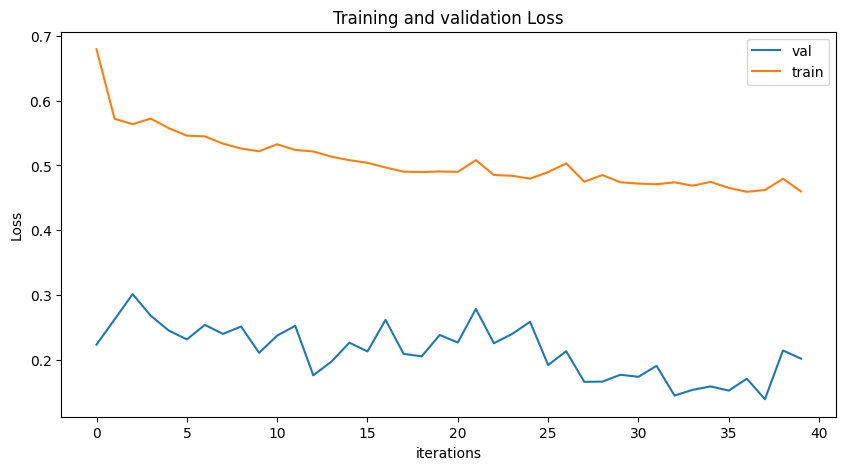

In [113]:
"""Plotting train and validation loss"""

plt.figure(figsize=(10,5))
plt.title("Training and validation Loss")
plt.plot(val_losses, label="val")
plt.plot(train_losses, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

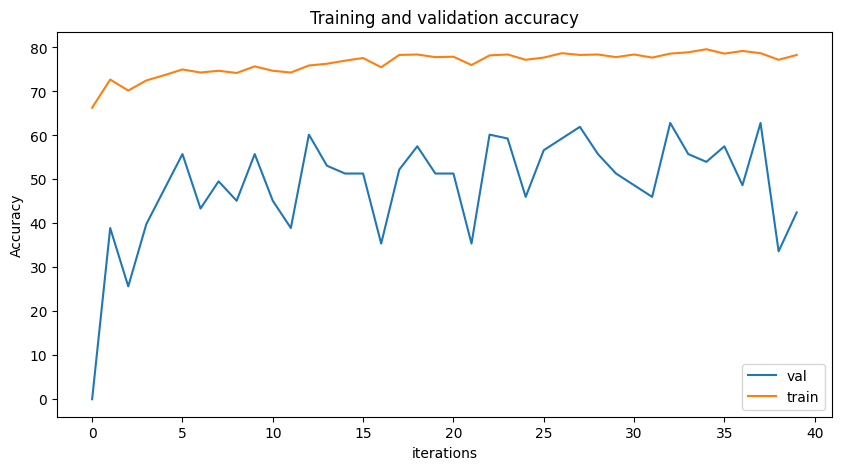

In [114]:
"""Plotting train and validation accuracy"""

plt.figure(figsize=(10,5))
plt.title("Training and validation accuracy")
plt.plot(val_acc, label="val")
plt.plot(train_acc, label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()